# LSTM Stock Predictor Using Closing Prices

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin closing prices to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
# data processing libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Neural networks
from tensorflow import device
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# plotting libraries
import matplotlib.pyplot as plt
# import hvplot.pandas

# import random and set the random seed for reproducibility
from numpy.random import seed
from tensorflow import random
seed(1)
random.set_seed(2)

In [2]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('Data/btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [3]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('Data/btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.head()

Date
2018-01-02    14754.129883
2018-01-03    15156.620117
2018-01-04    15180.080078
2018-01-05    16954.779297
2018-01-06    17172.300781
Name: Close, dtype: float64

In [4]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [5]:
def window_data(df, window, feature_col_number, target_col_number):
    '''
    function for generating a rolling window of data from a pd.Series
    Returns np.array for target and np.array for feature containing 
    '''
    # init empty containers
    X = []
    y = []

    # loop the length of the data, subtract window size to avoid out of index error
    for i in range(len(df) - window - 1):

        # generate data window for the current iteration through the loop
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]

        # append data to containers
        X.append(features)
        y.append(target)

    #return np.array of each container
    return np.array(X), np.array(y).reshape(-1, 1)

In [6]:
# generate dataset for RNN using a rolling window.
# Close (column 1) is the feature data.
# Close (column 1) is the target data.
window_size = 10
feature_column = 1
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [7]:
# Use 70% of the data for training and the remainder for testing (include shuffle=False to maintain a continuous dataset)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [8]:
# init scaler
scaler = MinMaxScaler()

# fit and transform X train and testing data
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit and transform scaler for y training and testing data
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)


In [9]:
# Reshape the features for the model, keep original shape and add an additional dimension.
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_train_scaled.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [10]:
# Build the LSTM model. 
# 3 LSTM layers, each with a droupout layer
# A Dense layer with one neuron for predictions.
input_layer = 30
h1 = 30
h2 = 30
input_shape = (X_train_scaled.shape[1],1)


model = Sequential()
model.add(LSTM(units=input_layer, activation='tanh', return_sequences=True, input_shape=input_shape))
model.add(Dropout(rate=0.1))
model.add(LSTM(units=h1, activation='tanh', return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(LSTM(units=h2, activation='tanh', return_sequences=False))
model.add(Dropout(rate=0.1))
model.add(Dense(1))


In [11]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [12]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 30)            3840      
                                                                 
 dropout (Dropout)           (None, 10, 30)            0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 30)            7320      
                                                                 
 dropout_1 (Dropout)         (None, 10, 30)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [13]:
# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=1, shuffle=False, verbose=1)

Epoch 1/10
372/372 [==============================] - 13s 15ms/step - loss: 0.0237
Epoch 2/10
372/372 [==============================] - 5s 13ms/step - loss: 0.0221
Epoch 3/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0282
Epoch 4/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0275
Epoch 5/10
372/372 [==============================] - 5s 13ms/step - loss: 0.0238
Epoch 6/10
372/372 [==============================] - 5s 13ms/step - loss: 0.0225
Epoch 7/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0207
Epoch 8/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0183
Epoch 9/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0190
Epoch 10/10
372/372 [==============================] - 5s 14ms/step - loss: 0.0191


---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [14]:
# Evaluate the model
model.evaluate(X_test_scaled, y_test)

5/5 [==============================] - 1s 7ms/step - loss: 0.0927


0.09269540756940842

In [15]:
# Make some predictions
predicted = model.predict(X_test_scaled)

In [16]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
real_prices.shape

(160, 1)

In [17]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real,Predicted
2019-02-20,3924.239990,3727.864258
2019-02-21,3974.050049,3749.519775
2019-02-22,3937.040039,3775.896973
2019-02-23,3983.530029,3800.719727
2019-02-24,4149.089844,3822.725098


<AxesSubplot:>

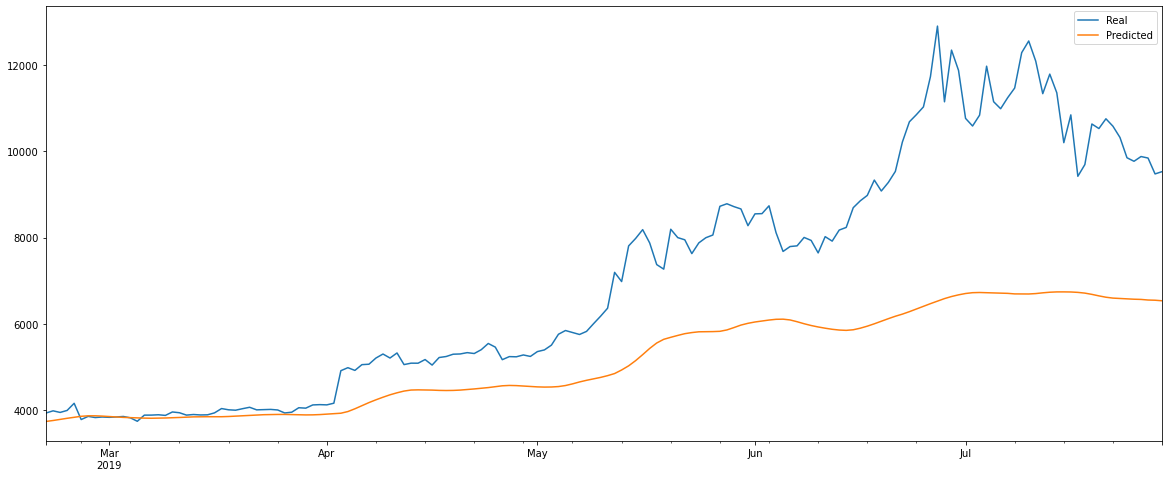

In [18]:
# Plot the real vs predicted values as a line chart
stocks.plot(figsize = (20,8))

<AxesSubplot:>

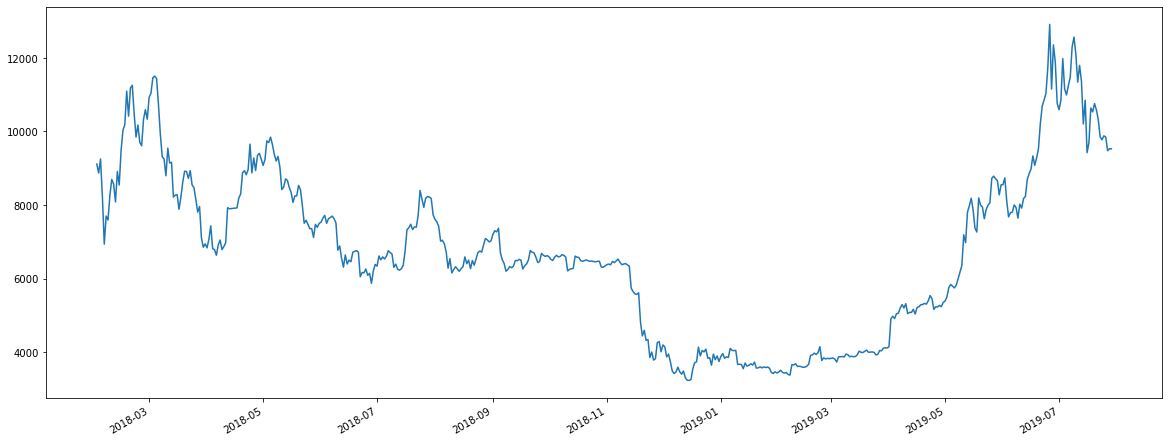

In [19]:
df.Close.plot(figsize = (20,8))